In [58]:
import warnings
from collections import defaultdict
from itertools import combinations, permutations
from typing import Iterable, DefaultDict, Set, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.linalg import inv, det
from scipy.io import loadmat
from scipy.stats import norm

np.set_printoptions(precision=4, linewidth=120)
warnings.filterwarnings('ignore')
%matplotlib inline

# Final project
## Problem 1

Let's first load the matrix $D$ and see what's in there.

In [59]:
D = loadmat("Data.mat")["D"]

print(D.shape)

(10000, 8)


### 1.1 Contruct the graph G

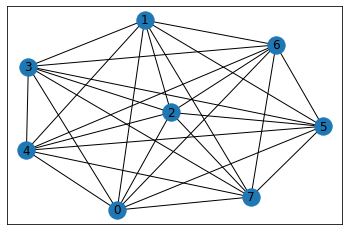

In [60]:
V = np.arange(D.shape[1])

def construct_graph(V: Iterable[int]) -> nx.classes.Graph:
    return nx.Graph(np.ones((len(V),)*2) - np.eye(len(V)))

nx.draw_networkx(construct_graph(V))

### 1.2 Part 2 of PC algo
#### 1.2.1 Compute the sample partial correlation

In this part, we look for the sample parital correlation $\hat{\rho}_{X_i, X_j | S}$. As we are allowed to assume that we deal with Gaussian multivariate distributions, this can be computed using the sample covariance matrix $\Sigma$. Let $X \equiv X_i, X_j$ From $\Sigma$, we can get $Var(X | S) = \Sigma_{X} - \Sigma_{XS}\Sigma_S^{-1}\Sigma_{SX} = \hat{A}$ where $\Sigma_X$ is the $2\times2$ part of $\Sigma$ for the variable of interests $\Sigma_S$ a $|S| \times |S|$, $\Sigma_{XS}$ a $2\times|S|$ and $\Sigma_{SX}$ a $|S| \times 2$. From $\hat{A}$ (which is symmetric because of the original assumption) we can get $\hat{\rho}_{X_i, X_j | S} = \frac{\hat{a}_{12}}{\sqrt{\hat{a}_{11} \cdot \hat{a}_{22}}}$

In [61]:
sigma = np.cov(D.T)
sigma.shape

(8, 8)

In [62]:
sigma

array([[ 1.0067e+00, -2.1921e-04,  6.4290e-01,  1.2569e-01,  5.5716e-01,  1.6617e-01,  3.3727e-01,  8.0818e-01],
       [-2.1921e-04,  1.0130e+00,  1.7308e-03,  1.3503e-02,  5.0584e-03,  2.6762e-03,  8.1927e-01,  6.1401e-03],
       [ 6.4290e-01,  1.7308e-03,  1.3857e+00,  2.9808e-01,  5.0780e-01,  1.4979e-01,  3.0984e-01,  1.4742e+00],
       [ 1.2569e-01,  1.3503e-02,  2.9808e-01,  1.0441e+00,  7.9219e-01,  2.5876e-01,  5.1741e-01,  1.5780e+00],
       [ 5.5716e-01,  5.0584e-03,  5.0780e-01,  7.9219e-01,  1.8094e+00,  6.0098e-01,  1.1206e+00,  1.9253e+00],
       [ 1.6617e-01,  2.6762e-03,  1.4979e-01,  2.5876e-01,  6.0098e-01,  1.2012e+00,  3.7257e-01,  6.1387e-01],
       [ 3.3727e-01,  8.1927e-01,  3.0984e-01,  5.1741e-01,  1.1206e+00,  3.7257e-01,  2.3502e+00,  1.2067e+00],
       [ 8.0818e-01,  6.1401e-03,  1.4742e+00,  1.5780e+00,  1.9253e+00,  6.1387e-01,  1.2067e+00,  4.4065e+00]])

In [63]:
def partial_corr(cov, x: int, y: int, S: Iterable[int]=None) -> float:
    if not S:  # 0th order
        return cov[x, y] / np.sqrt(cov[x, x] * cov[y, y])
    X = [x, y]
    A_hat = cov[np.ix_(X, X)] - cov[np.ix_(X, S)] @ inv(cov[np.ix_(S, S)]) @ cov[np.ix_(S, X)]
    return A_hat[0, 1] / np.sqrt(A_hat[0, 0] * A_hat[1, 1])

#### 1.2.2 Hypotheisis test for conditional independence
We create a method to check if the computed partial correlation is non null (double sided test). We use significance level $\alpha = 0.05$

Basically we want to check that we cannot reject the null hypothesis (the correlation is null). If we cannot reject the null hypothesis, as we have gaussian distribution then they are conditionally independent

In [64]:
ALPHA = 0.05

def test_corr(partial_corr: float, S: Iterable[int], n: int=D.shape[0], alpha: float=ALPHA) -> bool:
    return np.abs(partial_corr) <= norm.ppf(1 - alpha/2) / np.sqrt(n - len(S) - 3)

#### 1.2.3 Loop in PC algorithm
As we have only seen SGS in class, I opted for the implementation presented in [Kalisch07](http://www.jmlr.org/papers/volume8/kalisch07a/kalisch07a.pdf), presented in Section 2.2 of the paper

In [65]:
def PC_pop(V: Iterable[int], sigma) -> Tuple[nx.classes.Graph, DefaultDict[Tuple[int, int], Iterable[int]]]:
    G = construct_graph(V)
    separation_set = defaultdict(set)
    l = 0
    outer_loop_cond = True

    while outer_loop_cond:
        outer_loop_cond = False
        for i, j in permutations(V, 2):  # select an ordered pair
            adj_i = set(G.neighbors(i))
            if not (j in adj_i and len(adj_i - {j}) >= l):  # that are adjacent and |adj(G,i)\{j}| >= l
                continue

            for k in combinations(adj_i - {j}, l):  # choose k \subset adj(G, i) - {j} with |k| = l
                if test_corr(partial_corr(sigma, i, j, k), k):  # i, j are cond ind given k
                    G.remove_edge(i, j)
                    separation_set[(i, j)] |= set(k)
                    separation_set[(j, i)] |= set(k)
                    break

            outer_loop_cond = True  # There were some k s.t. |k| > l
        l += 1
    return G, separation_set

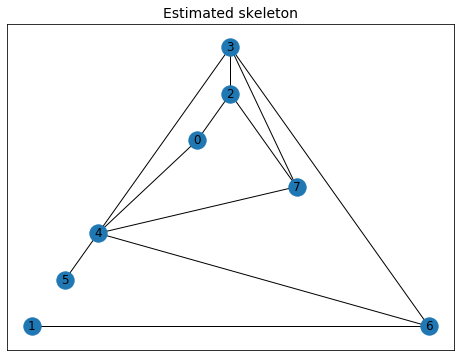

In [66]:
skeleton, sep_set = PC_pop(V, sigma)

plt.figure(figsize=(8, 6))
plt.title("Estimated skeleton", fontsize=14)
nx.draw_networkx(skeleton, pos=nx.planar_layout(skeleton))

### 1.3 Orient the v-structures
For this part, I use the last part of the PC algorithm which uses the separation sets identified previously.



_Note:_ As NetworkX doesn't handle Mixed Graph and as it is not impactful for our application, we represent "undirected" edges as bi-directionnal edges in a directed graph.

In [67]:
def orient_vstruct(skeleton: nx.classes.Graph, sep_set: DefaultDict[Tuple[int, int], Iterable[int]]) -> nx.classes.DiGraph:
    g_tilde = skeleton.to_directed()
    for i, j in combinations(g_tilde.nodes, 2):  # for all pair i,j
        adj_i = set(g_tilde.successors(i))
        adj_j = set(g_tilde.successors(j))
        if j in adj_i or i in adj_j:
            continue  # that are nonadjacent (i.e skip if they are adjacent)
        for k in (adj_i & adj_j):  # with common neighbour k
            if k not in sep_set[(i, j)]:
                print(f"There's a v-struct {i} -> {k} <- {j}")
                g_tilde.remove_edges_from([(k, i), (k, j)])  # replace i - k - j by i -> k <- j
    return g_tilde

There's a v-struct 0 -> 4 <- 3
There's a v-struct 1 -> 6 <- 3
There's a v-struct 1 -> 6 <- 4
There's a v-struct 2 -> 7 <- 4


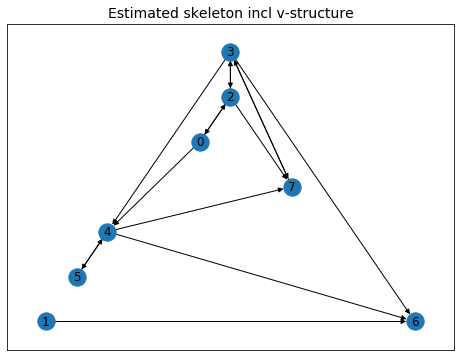

In [68]:
g_tilde = orient_vstruct(skeleton, sep_set)

plt.figure(figsize=(8, 6))
plt.title("Estimated skeleton incl v-structure", fontsize=14)
nx.draw_networkx(g_tilde, pos=nx.planar_layout(g_tilde))

## 2. Meek rules
Wre then try to orient as many as possible remaining "undirected" edges by applying the Meek rules (from Pearl09):
- $R_1$: Orient $a - b$ into $a \to b$ whenever there is an arrow $c \to a$ such that $c$ and $b$ are nonadjacent. (avoid unshielded collider)
- $R_2$: Orient $a - b$ into $a \to b$ whenever there is chain $a \to c \to b$. (avoid creating cycles)
- $R_3$: Orient $a - b$ into $a \to b$ whenever there are two chains $a - c \to b$ and $a - d \to b$ such that $c$ and $d$ are nonadjacent.
- $R_4$: Orient $a - b$ into $a \to b$ whenever there are two chains $a - c \to d$ and $c \to d \to b$ such that $c$ and $b$ are nonadjacent and $a$ and $d$ are adjacent.

But $R_4$ is not required as the starting orientation is limited to v-structures.

We first need some helper fuctions to determine some properties on edges in $\tilde{G}$

In [69]:
def _is_undirected(G: nx.classes.DiGraph, i: int, j: int) -> bool:
    return G.has_edge(i, j) and G.has_edge(j, i)

def _is_directed(G: nx.classes.DiGraph, i: int, j: int) -> bool:
    return G.has_edge(i, j) and not G.has_edge(j, i)

def _is_adjacent(G: nx.classes.DiGraph, i: int, j: int) -> bool:
    return G.has_edge(i, j) or G.has_edge(j, i)

def _get_between(G: nx.classes.DiGraph, i: int, j: int) -> Set[int]:
    """ return a set of nodes K, s.t. for k \in K, i -(>?) k -(>?) j """
    return set(G.successors(i)) & set(G.predecessors(j))

We can now write the orientation using the first 3 Meek rules

In [70]:
def apply_meek(G: nx.classes.DiGraph) -> nx.classes.DiGraph:
    made_progress = True
    while made_progress:
        old_G = G.copy()
        for a, b in combinations(G.nodes, 2):
            if not _is_undirected(G, a, b):
                continue

            # Rule 1
            for c in G.predecessors(a):  # c -(>?) a - b
                if _is_directed(G, c, a) and not _is_adjacent(G, c, b):
                    G.remove_edge(b, a)  # orient a -> b
                    print(f"Orient {a} -> {b}, because unshielded collider {c} -> {a} <- {b}")
                    break
            
            # Rule 2
            for c in _get_between(G, a, b):  # a -(>?) c -(>?) b
                if _is_directed(G, a, c) and _is_directed(G, c, b):  # a -> c -> b
                    G.remove_edge(b, a)
                    print(f"Orient {a} -> {b}, because potential cycle {a} -> {c} -> {b} -> {a}")
                    break
            
            # Rule 3
            for c, d in combinations(_get_between(G, a, b), 2):  # a -(>?) c -(>?) b and a -(>?) d -(>?) b
                if (_is_undirected(G, a, c) and _is_undirected(G, a, d) and
                    _is_directed(G, c, b) and _is_directed(G, d, b) and  # a - c -> b and a - d -> b
                    not _is_adjacent(G, c, d)):  # c and d are nonadjacent
                    G.remove_edge(b, a)
                    print(f"Orient {a} -> {b}")
                    break
        
        made_progress = not nx.is_isomorphic(old_G, G) # We made no progress in this epoch so we consider we are done
    
    for a, b in combinations(G.nodes, 2):
        if _is_undirected(G, a, b):
            print(f"{a} - {b} is still undirected")
    return G

Orient 3 -> 7, because potential cycle 3 -> 4 -> 7 -> 3
Orient 4 -> 5, because unshielded collider 0 -> 4 <- 5
0 - 2 is still undirected
2 - 3 is still undirected


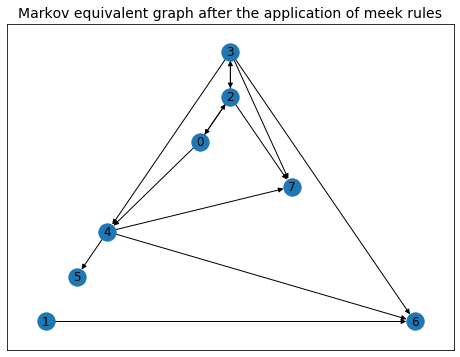

In [71]:
final_g = apply_meek(g_tilde.copy())

plt.figure(figsize=(8, 6))
plt.title("Markov equivalent graph after the application of meek rules", fontsize=14)
nx.draw_networkx(final_g, pos=nx.planar_layout(final_g))

## 3. Equivalence class

In our case we observe that almost all edges could be directed. In our case, only $0 - 2 - 3$ remain undirected.

This imply that we have **3 DAGS** in the Markov equivalence class with the following possible orientations that don't create a cycle or a new unshielded collider:
1. $0 \to 2 \to 3$
2. $0 \gets 2 \gets 3$
3. $0 \gets 2 \to 3$

## 4. Time complexity analysis
Let us consider a worst-case complexity analysis of `PC_pop`